In [1]:
%load_ext autoreload


In [2]:
%autoreload 2

In [3]:
ImageNetMean, ImageNetVariance = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

In [4]:
#IMPORTS
import os 
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.models as models

from pathlib import Path
from typing import *
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader

from utils import *
from datasets.dataset import MiniImageNetDataset

/anaconda/envs/maml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#READ CONFIG
config_dict = json.load(open("./config.json"))

In [6]:
train_classes = []; test_classes = []; val_classes = []
train_classes = os.listdir(config_dict['dataset']['train_path'])
test_classes = os.listdir(config_dict['dataset']['test_path'])
val_classes = os.listdir(config_dict['dataset']['val_path'])

In [7]:
config_dict['train_classes'] = len(train_classes)
config_dict['val_classes'] = len(val_classes)
config_dict['test_classes'] = len(test_classes)
config_dict['train_classes_list_debug'] = train_classes
config_dict['val_classes_list_debug'] = val_classes
config_dict['test_classes_list_debug'] = test_classes
   

In [8]:
print_config(config_dict)
train_class_distrib = class_distribution(config_dict['dataset']['train_path'],config_dict['train_classes_list_debug'])
val_class_distrib = class_distribution(config_dict['dataset']['val_path'],config_dict['val_classes_list_debug'])
test_class_distrib = class_distribution(config_dict['dataset']['test_path'],config_dict['test_classes_list_debug'])


dataset : {'root_path': '/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size', 'train_path': '/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size/train', 'test_path': '/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size/test', 'val_path': '/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size/val'}
model : {'torch_home': '/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Models'}
inner_loop_steps : 1
N_way : 5
K_shot : 5
train_classes : 64
val_classes : 16
test_classes : 20


Text(0, 0.5, 'No of Images')

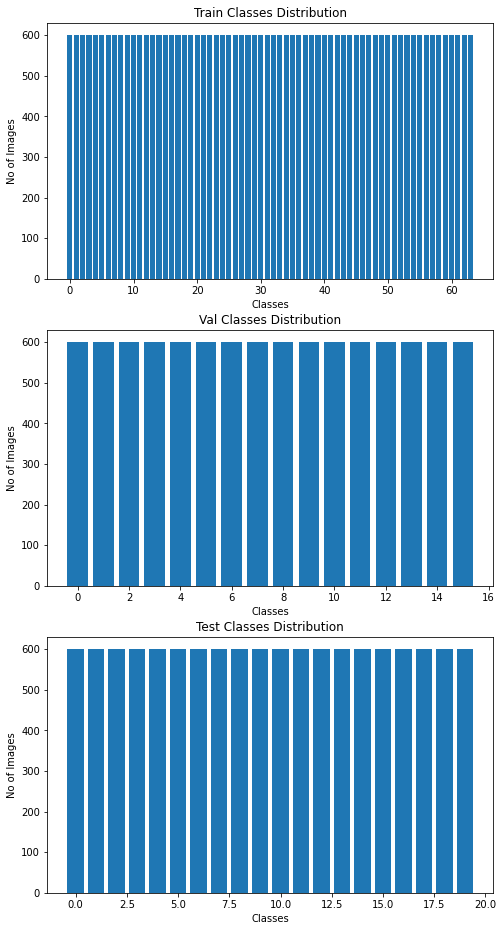

In [9]:
fig = plt.figure(figsize=(8,16))

fig.add_subplot(3,1,1)
plt.bar(list(range(len(train_class_distrib.keys()))), train_class_distrib.values())
plt.title("Train Classes Distribution")
plt.xlabel("Classes")
plt.ylabel("No of Images")


fig.add_subplot(3,1,2)
plt.bar(list(range(len(val_class_distrib.keys()))), val_class_distrib.values())
plt.title("Val Classes Distribution")
plt.xlabel("Classes")
plt.ylabel("No of Images")

fig.add_subplot(3,1,3)
plt.bar(list(range(len(test_class_distrib.keys()))), test_class_distrib.values())
plt.title("Test Classes Distribution")
plt.xlabel("Classes")
plt.ylabel("No of Images")


In [10]:
train_imgs = sample_imgs(config_dict['dataset']['train_path'],config_dict['train_classes_list_debug'],0.1,2)

Image of class type: n01749939


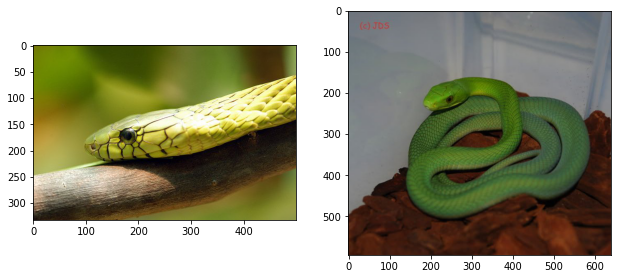

In [11]:
print(f"Image of class type: {list(train_imgs.keys())[0]}")
plot_images_grid(3,3,list(train_imgs.values())[0],figsize=(16,16))

Image of class type: n04612504


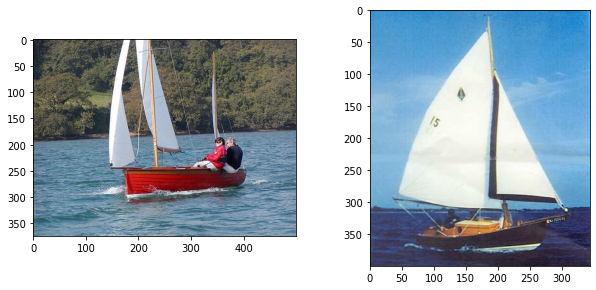

In [12]:
print(f"Image of class type: {list(train_imgs.keys())[1]}")
plot_images_grid(3,3,list(train_imgs.values())[1],figsize=(16,16))

In [13]:
transform = torch.nn.Sequential(
    transforms.Resize((256,256)),
    transforms.Normalize(ImageNetMean,ImageNetVariance)
)

In [14]:

mini_imagenet_dataset_train = MiniImageNetDataset(config_dict['dataset']['train_path'],N_way=5,\
    K_shot=5,query_samples_per_class=2, transform= transform )

No of classes in /home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size/train are 64


In [15]:
train_dl = DataLoader(mini_imagenet_dataset_train,batch_size= 2,shuffle= True)
val_dl = DataLoader(mini_imagenet_dataset_train,batch_size= 2,shuffle= True)

In [16]:
(xs,ys),(xq,yq) = next(iter(train_dl))

In [17]:
xs.shape , ys.shape , xq.shape , yq.shape

(torch.Size([2, 25, 3, 256, 256]),
 torch.Size([2, 25]),
 torch.Size([2, 10, 3, 256, 256]),
 torch.Size([2, 10]))

In [18]:
xs.dtype , ys.dtype

(torch.float32, torch.int64)

In [19]:
torch.max(xs)

tensor(2.6400)

In [20]:
os.environ['TORCH_HOME'] = config_dict['model']['torch_home']
resnet34 = models.resnet34(pretrained=True)

In [21]:
resnet34.fc = torch.nn.Linear(512,5)

In [22]:
resnet34.to("cuda:0")
optim = torch.optim.Adam(resnet34.parameters(), lr = 0.01)
do_train("cuda:0",torch.nn.BCEWithLogitsLoss(),optim,resnet34,train_dl,val_dl,config_dict)


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
batch_sz, support_sz, C, H, W = xs.shape
outp = resnet34(xs.reshape(-1,C,H,W).cuda())

In [ ]:
outp.device, outp.shape

(device(type='cuda', index=0), torch.Size([50, 5]))